# Methods for defining the mesoscale structure of higher-order networks

Here we show a variety of approaches for defining the mesoscale structure of higher-order networks. 
1) We provide an implementation of a spectral method, that we call **Hypergraph Spectral Clustering**, which recovers hard communities via hypergraph cut optimization: ["_Learning with hypergraphs: Clustering, classification, and embedding", Zhou D., Huang J., Schölkopf B._](https://proceedings.neurips.cc/paper/2006/file/dff8e9c2ac33381546d96deea9922999-Paper.pdf)

2) We also implement different generative models able to extract overlapping communities and jointly infer hyperedges (**Hypergraph-MT**), allowing to capture a variety of mesoscale organizations, including both disassortative and assortative community structure (**Hy-MMSBM**): [_"Inference of hyperedges and overlapping communities in hypergraphs", Contisciani M., Battiston F., De Bacco_](https://www.nature.com/articles/s41467-022-34714-7) and [_"Generalized inference of mesoscale structures in higher-order networks", Ruggeri N., Contisciani M., Battiston F., De Bacco C._](https://arxiv.org/abs/2301.11226)

3) Finally, we provide a method able to extract hyperlink communities, where interactions, and not system units, are clustered across different hypergraph modules. [TO UPDATE]

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# external
import sys
import random
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# core python modules
sys.path.append("..")
import hnx
from hnx.core.hypergraph import Hypergraph
from hnx.readwrite import load_hypergraph
from hnx.utils import normalize_array, calculate_permutation_matrix
from hnx.communities.hy_sc.model import HySC
from hnx.communities.hypergraph_mt.model import HypergraphMT
from hnx.communities.hy_mmsbm.model import HyMMSBM

### Import the data

In [3]:
dataset = 'workplace'
H = load_hypergraph(f"../test_data/{dataset}/{dataset}.pickle", "pickle")
print(H)

Hypergraph with 92 nodes and 788 edges.
Distribution of hyperedge sizes: {2: 742, 3: 44, 4: 2}


In [4]:
K = 5  # number of communities
seed = 20  # random seed
n_realizations = 10  # number of realizations with different random initialization

### 1) Train Hypergraph Spectral Clustering

In [5]:
%%time

model = HySC(
    seed=seed, 
    n_realizations=n_realizations
)
u_HySC = model.fit(
    H, 
    K=K, 
    weighted_L=False
)

CPU times: user 481 ms, sys: 175 ms, total: 656 ms
Wall time: 204 ms


### 2) Train Hypergraph-MT

###### Note

In this model you have the possibility to give extra parameters:
```
available_extra_params = [
            "fix_communities",  # flag to keep the communities fixed
            "fix_w",  # flag to keep the affinity matrix fixed
            "gammaU",  # constant to regularize the communities
            "gammaW",  # constant to regularize the affinity matrix
            # initialize u with input array, stored file, or the solution of the Hypergraph Spectral Clustering
            "initialize_u0",
            "initialize_w0",  # initialize w with input array or from a stored file
            "out_inference",  # flag to store the inferred parameters
            "out_folder",  # path to store the output
            "end_file",  # output file suffix
        ]
```

In [6]:
max_iter = 500  # maximum number of EM iteration steps before aborting
check_convergence_every = 1 # number of steps in between every convergence check
normalizeU = False  # if True, then the membership matrix u is normalized such that every row sums to 1
baseline_r0 = False  # if True, then for the first iteration u is initialized around the solution of the Hypergraph Spectral Clustering
verbose = False  # flag to print details

In [7]:
%%time

model = HypergraphMT(
    n_realizations=n_realizations, 
    max_iter=max_iter, 
    check_convergence_every=check_convergence_every, 
    verbose=verbose
)
u_HypergraphMT, w_HypergraphMT, _ = model.fit(H, 
                                               K=K, 
                                               seed=seed, 
                                               normalizeU=normalizeU, 
                                               baseline_r0=baseline_r0
                                              )

CPU times: user 17 s, sys: 77.4 ms, total: 17.1 s
Wall time: 17.1 s


###### Remark

Hypergraph-MT reduces the dimension of the affinity matrix $w$ and allows the feasibility of the model through the assortative assumption, such that a hyperedge is more likely to exist when all nodes in it belong to the same group. For this reason, the affinity matrix $w$ has dimension $D \times K$, where $D$ is the maximum hyperedge size in the dataset and $K$ is the number of communities. In our experiment, we do not consider self-loops so tenchically it has dimension $(D-1) \times K$.  Every entry $w_{dk}$ represents the propensity of interactions of size $d$ within entities of the same community $k$.

In [8]:
w_HypergraphMT.shape

(3, 5)

In [9]:
np.round(w_HypergraphMT, 3)

array([[1.2130e+01, 1.6346e+01, 8.1090e+00, 6.1320e+00, 1.2244e+01],
       [3.0000e-03, 3.4000e-02, 9.0000e-03, 3.0000e-03, 3.5000e-02],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])

### 3) Train Hy-MMSBM

###### Note

In this model you have the option to provide the membership matrix ```u``` and/or the affinity matrix ```w``` at initialization. If either of them are given, these are considered fixed parameters and will not be inferred. In addition, you can specify the maximum hyperedge size (```max_hye_size```), which is otherwise inferred once a hypergraph is observed. Furthermore, you can decide the priors for $u$ (```u_prior```) and $w$ (```w_prior```), as rates of exponential distributions. These can be specified as non-negative numbers (priors equal to 0 correspond to no prior), or as numpy arrays if a non-uniform prior is expected.

In [10]:
assortative = True  # whether the affinity matrix w is expected to be diagonal

In [12]:
%%time
np.random.seed(seed)
random.seed(seed)
    
# Train some models with different random initializations, choose the best one in terms of likelihood
best_model = None
best_loglik = float("-inf")
for j in range(n_realizations):
    model = HyMMSBM(
        K=K, 
        assortative=assortative
    )
    model.fit(
        H, 
        n_iter=max_iter
    )

    log_lik = model.log_likelihood(H)
    if log_lik > best_loglik:
        best_model = model
        best_loglik = log_lik

u_HyMMSBM = best_model.u
w_HyMMSBM = best_model.w

CPU times: user 4.7 s, sys: 27.3 ms, total: 4.73 s
Wall time: 4.74 s


###### Remark

Hy-MMSBM allows for a tractable and scalable inference by making use of a bilinear form. This allows to keep the dimension of the affinity matrix $w$ equal to $K \times K$ and to let $w$ be free to capture different community structures, e.g., disassortative and assortative.

In [13]:
w_HyMMSBM.shape

(5, 5)

In [14]:
np.round(w_HyMMSBM, 3)
# Note: the off-diagonal entries are zeros because we impose assortative=True

array([[0.777, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.533, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.883, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 1.151, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.457]])

### 4) 

In [10]:
# TODO

### Analyse communities

Workplace does not have ground truth communities, but it provides node metadata that describe the departments the nodes belong to. We use this information just as a reference for comparison.

In [15]:
departments = [H.get_meta(n)['classID'] for n in sorted(H.get_nodes())]
u_ref = np.zeros(shape=(H.num_nodes(), K))
for i in range(H.num_nodes()):
    u_ref[i][departments[i]] = 1

Let's now normalize by row the mixed-memberships inferred by Hypergraph-MT and Hy-MMSBM. 

In [16]:
u_HypergraphMT = normalize_array(u_HypergraphMT, axis=1)
u_HyMMSBM = normalize_array(u_HyMMSBM, axis=1)

Let's also permute the columns of the inferred membership matrices such that we have a higher correspondence with the reference.

In [17]:
P = calculate_permutation_matrix(u_ref=u_ref, u_pred=u_HySC)
u_HySC = np.dot(u_HySC, P)

P = calculate_permutation_matrix(u_ref=u_ref, u_pred=u_HypergraphMT)
u_HypergraphMT = np.dot(u_HypergraphMT, P)

P = calculate_permutation_matrix(u_ref=u_ref, u_pred=u_HyMMSBM)
u_HyMMSBM = np.dot(u_HyMMSBM, P)

Let's now visualize them.

In [18]:
params = {'legend.fontsize': '14',
         'axes.labelsize': '14',
         'axes.titlesize':'15',
         'xtick.labelsize':'12',
         'ytick.labelsize':'12'}
plt.rcParams.update(params)

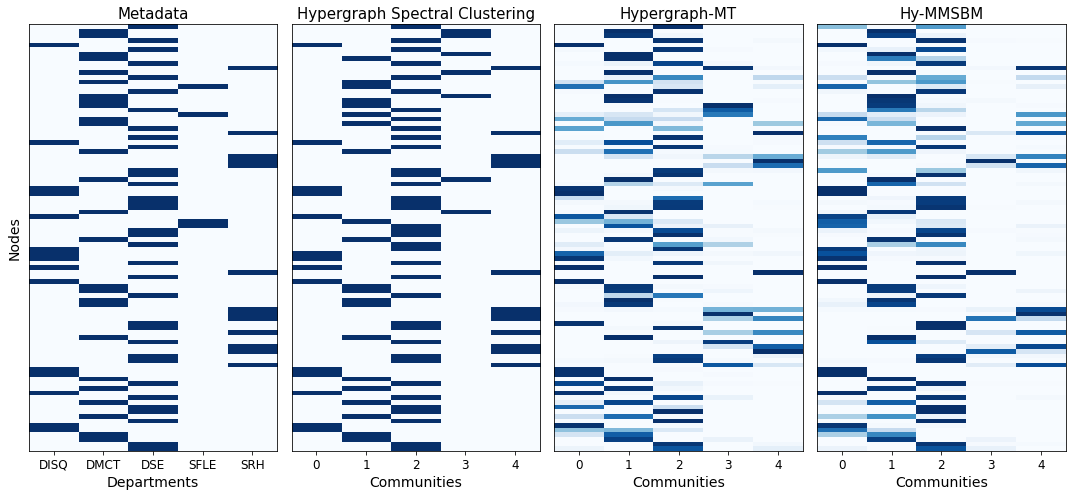

In [19]:
titles = ['Metadata', 'Hypergraph Spectral Clustering', 'Hypergraph-MT', 'Hy-MMSBM']

fig, ax = plt.subplots(1, 4, figsize=(15, 7), sharey=True)

ax[0].matshow(u_ref, aspect='auto', cmap='Blues')
ax[0].set(
    title='Metadata',
    xticks=[0,1,2,3,4],
    xticklabels = ['DISQ', 'DMCT', 'DSE', 'SFLE', 'SRH'],
    yticks = [],
    xlabel='Departments',
    ylabel='Nodes',
)

ax[1].matshow(u_HySC, aspect='auto', cmap='Blues')
ax[2].matshow(u_HypergraphMT, aspect='auto', cmap='Blues')
ax[3].matshow(u_HyMMSBM, aspect='auto', cmap='Blues')

for i in [1, 2, 3]:
    ax[i].set(
        title=titles[i],
        yticks = [],
        xlabel='Communities',
    )

for i in np.arange(4):
    ax[i].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)


plt.tight_layout()
plt.show()

# Q
Vogliamo uniformare HySC, Hypergraph_MT con HyMMSBM? Per esempio, vogliamo mettere sempre n_realization fuori? vogliamo togliere l'opzione per salvare?